In [1]:
# Acá van las librerías que vamos a ocupar :)
import csv                                   # Para leer archivo
import numpy as np                           # Útil para procesos matemáticos
from sympy import *                          # Útil para calcular derivadas 
from scipy.optimize import fsolve            # Útil para encontrar soluciónes númericas 
from scipy.interpolate import interp1d       # Librería para hacer interpolaciones
import matplotlib.pyplot as plt              # Plotting 
from datetime import date as dt              # Para trabajar con fechas y diferencias de fechas 
from datetime import datetime
from dateutil import relativedelta as rd

## Proyecto Tarea 4

### Parte I

El objetivo de esta parte del proyecto es producir un código capaz de determinar la tasa interna de retorno (TIR), la duración y la convexividad de un bono con cupones, con una precisión de al menos 3 cifras significativas. 

El valor de un bono con cupones viene dado por la siguiente expresión, vista en clases:

$$ V(t)=Pe^{-y(T-t)}+\sum_{j=1}^N C_j e^{-y(t_j-t)}, $$

donde $P$ es el monto principal, $T$ es el tiempo final, $t$ es el tiempo actual, C_j es lo pagado por cada cupon, N es el numero de cupones y $t_j$ los tiempos en los que debemos pagar cada cupon e $y$ es el TIR. Podemos expresar $t_j-t=j/A$, dado intervalos de tiempos equitativos. Adémas, diremos que todos los $C_j$ son iguales y estan dados por:

$$ C_j=C=\frac{P r}{A},$$

donde $r$ es la taza anual de los cupones y $A$ es 1 o 2 dependiendo de si los cupones son anuales o bianuales, respectivamente. La Duración y la Convexidad vienen dadas por:

$$ D=-\frac{1}{V}\frac{dV}{dy}, \qquad C=\frac{1}{V}\frac{d^2V}{dy^2}. $$

Calculando, obtenemos:

$$ D=\frac{P}{V}(T-t)e^{-y(T-t)} + \sum_{j=1}^N\frac{C_j}{V}(t_j-t)e^{-y(t_j-t)} , $$

$$ C=\frac{P}{V}(T-t)^2e^{-y(T-t)} + \sum_{j=1}^N\frac{C_j}{V}(t_j-t)^2e^{-y(t_j-t)} . $$

Partamos por los inputs. Para la información a recibir para el cálculo no voy a hacer una interfaz esta vez, pero dejo abajo una celda comentada donde se pueden introducir los valores. Razón: más rapido para ambos :P 

In [2]:
# Partamos definiendo un par de funciones útiles 

# Función que convierte las fechas a objetos datetime 
def str_to_dt(date): 
    date = date.split('-')
    return dt(int(date[0]), int(date[1]), int(date[2]))

# Función para obtener días entre dos fechas
def delta_days(d1,d2):
    diff = d1 - d2
    return diff.days
    
# Función que retorna factor de división según tipo de bono
def div_factor(tipo_de_bono):
    if tipo_de_bono =='a': return 1
    elif tipo_de_bono == 'b': return 2
    return None

# Función porcentage a número (A prueba de ingenieros comerciales)
def percent_to_num(percent): return percent/100 # xD

# Espacio para ingresar variables 
# Algunas van dentro de funciones que me entregan un valor trabajable
p = 100000000                  # Monto Principal 
t0 = str_to_dt('2023-6-1')     # Fecha actual (formato: año-mes-día)
#t0 = datetime.datetime.now()  # También puedes poner automaticamente hoy descomentando esta linea
tf = str_to_dt('2029-6-1')     # Fecha de madurez  (formato: año-mes-día)
a_or_b = div_factor('a')       # Cupones anuales (Ingresar 'a') o bi anuales (Ingresar 'b') 
r = percent_to_num(3)          # Tasa anual de los cupones (en %)
v0 = 96000000                  # precio actual del bono


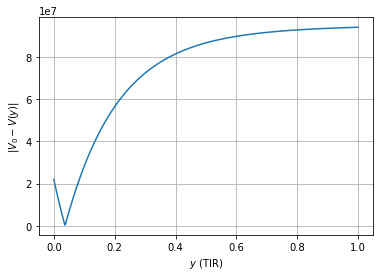

El TIR inicial propuesto con el error más pequeño encontrado es y=0.03607214428857715.
El TIR final calculado númericamente es y=0.03688, con un error de 1.49E-08.


In [3]:
# Calculemos lo que nos piden

# Primero definimos la función para el valor del bono
def value_b(y, p, t0, tf, a_or_b, r):
    dt = int(delta_days(tf,t0)/365)
    n_cupones = dt*a_or_b
    value = p*np.e**(-y*dt)
    for i in range(1,n_cupones+1):
        value += (p*r/a_or_b)*np.e**(-y*i/a_or_b)
    return value

# Diferencia absoluta del valor deseado + TIR
def value_vs_v0(y, p, t0, tf, a_or_b, r, v0):
    return (abs(v0 - value_b(y, p, t0, tf, a_or_b, r)),y)

# Diferencia absoluta del valor deseado
def just_value_vs_v0(y, p, t0, tf, a_or_b, r, v0):
    return abs(v0 - value_b(y, p, t0, tf, a_or_b, r))

# Ahora graficamos la diferencia del valor para tener una idea general de donde vamos
# a encontrar nuestra solución.
ys = np.linspace(0,1,500)
plt.plot(ys, value_vs_v0(ys, p, t0, tf, a_or_b, r, v0)[0])
plt.xlabel("$y$ (TIR)")
plt.ylabel(r"$|V_0-V(y)|$")
plt.grid()
plt.show()

# Checkeando valor exacto de minimo
y_guess = sorted([(value_vs_v0(y, p, t0, tf, a_or_b, r, v0), y) for y in ys])[0][1]
print(r'El TIR inicial propuesto con el error más pequeño encontrado es y={}.'.format(y_guess))

# Finalmente, optimizamos con fsolve
y_solution = fsolve(just_value_vs_v0, y_guess, args=(p, t0, tf, a_or_b, r, v0))[0]
v_solved = value_b(y_solution, p, t0, tf, a_or_b, r)
err = abs(v0-v_solved)

print(r'El TIR final calculado númericamente es y={:.5f}, con un error de {:.2E}.'.format(y_solution, err))

Vemos como en este caso logramos una precisión de 8 cifras significativas, las cuales son más que suficientes. Calculemos el resto de los valores solicitados en base al TIR encontrado. 

In [4]:
def duration(y, p, t0, tf, a_or_b, r):
    v = value_b(y, p, t0, tf, a_or_b, r)
    dt = int(delta_days(tf,t0)/365)
    n_cupones = dt*a_or_b
    value = (p/v)*dt*np.e**(-y*dt)
    for i in range(1,n_cupones+1):
        value += ((p*r/a_or_b)/v)*(i/a_or_b)*np.e**(-y*i/a_or_b)
    return value

def convexity(y, p, t0, tf, a_or_b, r):
    v = value_b(y, p, t0, tf, a_or_b, r)
    dt = int(delta_days(tf,t0)/365)
    n_cupones = dt*a_or_b
    value = (p/(v))*(dt**2)*np.e**(-y*dt)
    for i in range(1,n_cupones+1):
        value += ((p*r/a_or_b)/(v))*((i/a_or_b)**2)*np.e**(-y*i/a_or_b)
    return value


dur = duration(y_solution, p, t0, tf, a_or_b, r)
conv = convexity(y_solution, p, t0, tf, a_or_b, r)

print(r'La duración final es D={:.5f} y la convexidad es C={:.5f}.'.format(dur,conv))


La duración final es D=5.56945 y la convexidad es C=32.43645.


### Parte 2

Con la tabla entregada de TIR's de los bonos del tesoro de Estados Unidos en distintas fechas para distintos periodos, se nos pide:

a) Calcular mediante interpolación lineal el factor de descuento asociado a cualquier plazo entre un mes y 30 años. Para esto recordamos que el factor de descuento estaría dado por 

$$ DF=\frac{1}{(1+TIR_T)^T}. $$ 

In [5]:
# Partamos con extraer los TIRs de la tabla 
with open('YTMs.csv', 'r', encoding='utf-8') as file:
    data = csv.DictReader(file)
    data = [row for row in data] 

# data: Lista de entradas en el .csv en formato de diccionario, por ejemplo...
print('Ejemplo data primera fecha: {}'.format(data[0]))

# Trabajemos data para tener solo listas de TIRs
tir_data = []
for d in data: 
    d.pop('Date')
    tir_data.append([float(x)/100 for x in d.values()])

# Ejemplo solo TIRs primera fecha:
print('Ejemplo solo TIRs primera fecha: {}'.format(tir_data[0]))

# Fechas en unidades de años: 
xs = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

Ejemplo data primera fecha: {'Date': '05/01/2019', '1 Mo': '2.42', '2 Mo': '2.41', '3 Mo': '2.43', '6 Mo': '2.44', '1 Yr': '2.39', '2 Yr': '2.31', '3 Yr': '2.28', '5 Yr': '2.31', '7 Yr': '2.41', '10 Yr': '2.52', '20 Yr': '2.74', '30 Yr': '2.92'}
Ejemplo solo TIRs primera fecha: [0.0242, 0.0241, 0.024300000000000002, 0.024399999999999998, 0.0239, 0.0231, 0.022799999999999997, 0.0231, 0.0241, 0.0252, 0.0274, 0.0292]


Con los datos ya trabajados hacer la interpolación lineal en python es directo, gracias al uso de la librería scipy. Si necesitan evidencia de que se como interpolar linealmente puedo conseguir un certificado de mi profe de probabilidad y estadística (Chiste! No quiero hacer eso).

A continuación, definimos la función para el factor de descuento, la función que interpole el TIR dado los datos de una fecha y gráficamos para la primera y última fecha en la tabla entregada. 

Text(0.5, 0, 'T (Años)')

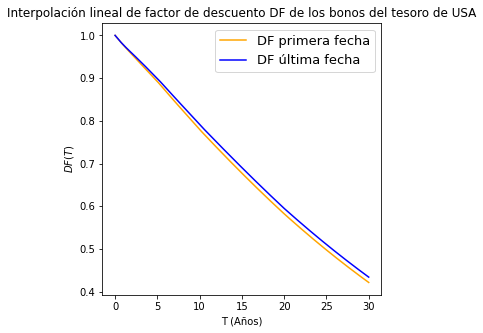

In [6]:
# Función que calcula el factor de descuento según tir y tf en años
def df(tir,tf):
    return (1+tir)**(-tf)

x = np.linspace(0,30,500)

# Interpolaciones
y1 = df(np.interp(x,xs,tir_data[0]), x)
y2 = df(np.interp(x,xs,tir_data[-1]), x)

fig, ax = plt.subplots(figsize=(5,5))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax1, = ax.plot(x, y1, color='orange', label='DF primera fecha')
ax2, = ax.plot(x, y2, color='blue', label='DF última fecha')

ax.legend(handles=[ax1,ax2], prop={'size': 13})
ax.set_title('Interpolación lineal de factor de descuento DF de los bonos del tesoro de USA')
ax.set_ylabel(r'$DF(T)$')
ax.set_xlabel('T (Años)')

b) En base a nuestras interpolaciones lineales para los $DF(T)$ de cada fecha, dbeemos calcular y gráficar las tasas futuras implicitas para las mismas fechas. Para esto, recordamos la definición de factor de descuento en base a esta tasa:

$$ DF(t;T)=e^{-\int_t^T r(\tau)d\tau}. $$

Asumiendo que la tasa es aproximadamente constante entre distintos tiempos, podemos usar "boostrapping" para calcular esta tasa, tal que:

$$ r(t:T)=-\frac{\partial}{\partial T}\ln{DF(t;T)}|_{T=t}. $$

Si introducimos la definición pasada para el factor de descuento en función del TIR en esta igualdad, obtenemos 

$$ r(t:T)= \frac{\partial}{\partial T}(T \ln{(1+TIR)})=\ln{(1+TIR)} $$

Cálculemos y gráfiquemos estos valores.

Text(0.5, 0, 'T (Años)')

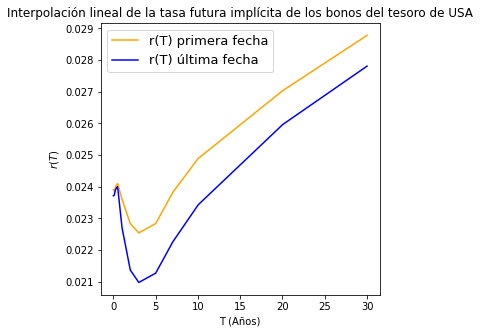

In [7]:
def rf(tir):
    return np.log(1+tir)

x = np.linspace(0,30,500)

# Interpolaciones
y1 = rf(np.interp(x,xs,tir_data[0]))
y2 = rf(np.interp(x,xs,tir_data[-1]))

fig, ax = plt.subplots(figsize=(5,5))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax1, = ax.plot(x, y1, color='orange', label='r(T) primera fecha')
ax2, = ax.plot(x, y2, color='blue', label='r(T) última fecha')

ax.legend(handles=[ax1,ax2], prop={'size': 13})
ax.set_title('Interpolación lineal de la tasa futura implícita de los bonos del tesoro de USA')
ax.set_ylabel(r'$r(T)$')
ax.set_xlabel('T (Años)')

También podríamos ocupar una aproximación discreta, tomando el diferencial como una diferencia en df partido por una diferencia en dt, como se muestra a continuación.

Text(0.5, 0, 'T (Años)')

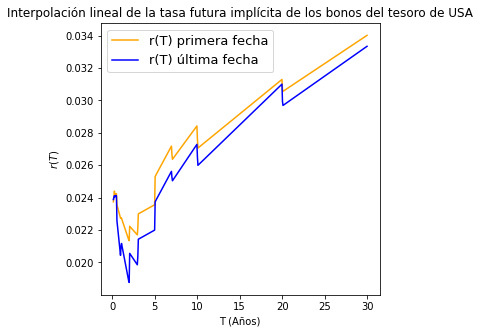

In [8]:
x = np.linspace(1/12,30,500)
x2 = x[1:]

# Interpolaciones
y1 = df(np.interp(x,xs,tir_data[0]), x)
y2 = df(np.interp(x,xs,tir_data[-1]), x)

dt = x[1] - x[0]

r1 = []
for i in range(1,len(y1)):
    r1.append(-np.log(y1[i]/y1[i-1])/dt)

r2 = []
for i in range(1,len(y2)):
    r2.append(-np.log(y2[i]/y2[i-1])/dt)


fig, ax = plt.subplots(figsize=(5,5))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax1, = ax.plot(x2, r1, color='orange', label='r(T) primera fecha')
ax2, = ax.plot(x2, r2, color='blue', label='r(T) última fecha')

ax.legend(handles=[ax1,ax2], prop={'size': 13})
ax.set_title('Interpolación lineal de la tasa futura implícita de los bonos del tesoro de USA')
ax.set_ylabel(r'$r(T)$')
ax.set_xlabel('T (Años)')